
# **Diagnosis Prediction CNN**

This notebook will develop an artifical neural network to perform diagnosis prediction of OASIS-2 (https://www.oasis-brains.org/) based on neuroimaging and clincial data. The work was inspired by the work of Battineni et al.  using Support Vector Machines for the same problem.

DISCLAIMER: Some code for building/compiling the model was adapted from Google Machine Learning Crash Course (https://developers.google.com/machine-learning/crash-course)

## **i. Imports and subfunctions**

In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import shutil
import sys
import itertools
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, \
                            precision_recall_fscore_support as score
from matplotlib import pyplot as plt

def plot_curve(epochs, hist, list_of_metrics,
               figure_name):
  """
  Plot a curve of one or more
  classification metrics vs epoch.
  """ 
  # Figure details   
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  # Plot
  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)
  plt.legend()
  plt.grid()
  plt.savefig(os.path.join(outdir, figure_name))


def create_model(my_learning_rate, my_feature_layer):
  """
  Create and compile a neural network.
  """
  
  # Create sequential model with feature/hiddne/dropout/output layer
  model = tf.keras.models.Sequential()
  model.add(my_feature_layer)
  model.add(tf.keras.layers.Dense(units=5, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

  # Compile model     
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, dataset, epochs, label_name,
                batch_size=None, validation_split=0.1):
  """
  Train the model by feeding it data.
  """

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label    = np.array(features.pop(label_name))
  history  = model.fit(x=features, y=label, batch_size=batch_size,
                       epochs=epochs, shuffle=True,
                       validation_split=validation_split) 
  
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist   = pd.DataFrame(history.history)

  return epochs, hist


def plot_confusion_matrix(cm,
                          target_names,
                          figure_name,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels

    Given a sklearn confusion matrix make a nice plot.

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    figure_name: name of figure to save

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    # Calculate metrics
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Colour maps
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    # Figure details
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add tick labels
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    # Normalise values
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create matrix plot
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    # Plot figure
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy,
                                                                            misclass))
    plt.savefig(os.path.join(outdir, figure_name))
    plt.show()

print('Author: Hugo Dugdale')
print('Email: hugo.dugdale@hotmail.co.uk')

Author: Hugo Dugdale
Email: hugo.dugdale@hotmail.co.uk


## **ii. General setup**

In [2]:
# Directories
basedir = "/content/drive/MyDrive/Diagnosis_prediction"
datadir = os.path.join(basedir, "Data")
outdir  = os.path.join(basedir, "Output")
shutil.rmtree(outdir, ignore_errors=True)
os.makedirs(outdir, exist_ok=True)

# Load data
data_csv      = os.path.join(datadir, "oasis_longitudinal_demographics.xlsx")
df            = pd.read_excel(data_csv)
df.rename(columns={"MR Delay" : "MR_delay",
                   "M/F"      : "Sex"},
          inplace=True)
data_df       = df.dropna()
model_data_df = data_df

# Drop unwanted columns
good_columns  = ["Visit", "MR_delay", "Sex", 
                 "Group", "MMSE", "CDR",
                 "eTIV", "nWBV", "ASF"]
model_data_df = model_data_df[good_columns]

# Define label name
label_name = "Group"

# Normalise values (train and test)
model_data_df_mean = model_data_df.mean(numeric_only=True)
model_data_df_std  = model_data_df.std(numeric_only=True)
model_data_df_norm = (model_data_df - model_data_df_mean)/model_data_df_std

# Add non normalised labels and CDR back on
for column in ["Group", "CDR", "Sex", "Visit"]:
  model_data_df_norm[column] = model_data_df[column]

# Numeric label  conversion dict
label_conversions = {"Group" : {"Nondemented" : 0,
                                "Converted"   : 1,
                                "Demented"    : 2
                                },
                     "Sex"   : {"M" : 0,
                                "F" : 1
                                }
                     }
inv_label_conversions = {}
for col in label_conversions:
  model_data_df_norm[col] = model_data_df_norm[col].replace(label_conversions[col])
  inv_label_conversions[col] = {v:k for k, v in label_conversions[col].items()}
display(model_data_df_norm.head())

# Split into train and test sets
train_df = model_data_df_norm.sample(frac=0.8, 
                                     random_state=100)
test_df  = model_data_df_norm.drop(train_df.index)
train_df = train_df.reindex(np.random.permutation(train_df.index))

,ASF,CDR,Group,MMSE,MR_delay,Sex,Visit,eTIV,nWBV
0,-2.268033,0.0,0,-0.110327,-0.938740,0,1,2.825198,-0.891939
1,-2.325775,0.0,0,0.697726,-0.225342,0,2,2.927208,-1.289432
5,1.829082,0.0,0,0.159024,-0.938740,1,1,-1.562664,-0.537725
6,1.962968,0.0,0,-0.110327,-0.098897,1,2,-1.649315,-0.307800
7,-1.128760,0.0,0,0.159024,-0.938740,0,1,1.129895,-0.485145


## **1. Neural network**

### 1.1 Train model

Epoch 1/300
6/6 [==============================] - 3s 173ms/step - loss: 1.1078 - accuracy: 0.2756 - val_loss: 1.1440 - val_accuracy: 0.2069
Epoch 2/300
6/6 [==============================] - 0s 16ms/step - loss: 1.1127 - accuracy: 0.3346 - val_loss: 1.1398 - val_accuracy: 0.3103
Epoch 3/300
6/6 [==============================] - 0s 22ms/step - loss: 1.1050 - accuracy: 0.3228 - val_loss: 1.1356 - val_accuracy: 0.3103
Epoch 4/300
6/6 [==============================] - 0s 33ms/step - loss: 1.1099 - accuracy: 0.3189 - val_loss: 1.1319 - val_accuracy: 0.3448
Epoch 5/300
6/6 [==============================] - 0s 17ms/step - loss: 1.0961 - accuracy: 0.3661 - val_loss: 1.1282 - val_accuracy: 0.3448
Epoch 6/300
6/6 [==============================] - 0s 20ms/step - loss: 1.0955 - accuracy: 0.4094 - val_loss: 1.1245 - val_accuracy: 0.3103
Epoch 7/300
6/6 [==============================] - 0s 24ms/step - loss: 1.0833 - accuracy: 0.4528 - val_loss: 1.1200 - val_accuracy: 0.3103
Epoch 8/300
6/6 [==

[0.47391483187675476, 0.8309859037399292]

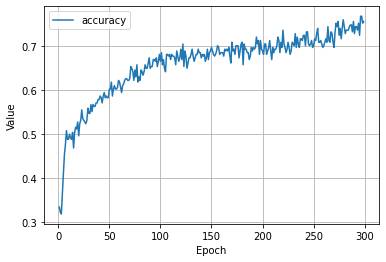

In [3]:
# Create feature layer
feature_columns = []
for feature_name in [x for x in good_columns if x != "Group"]:
  feature_values = tf.feature_column.numeric_column(feature_name)
  feature_columns.append(feature_values)
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# The following variables are the hyperparameters.
learning_rate    = 0.0006
epochs           = 300
batch_size       = 50
validation_split = 0.1

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, train_df, epochs,
                           label_name, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot,
           "model_training_accuracy")

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label    = np.array(test_features.pop(label_name))
print("\nEvaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label,
                  batch_size=batch_size)

### 1.2 Evaluate model

,ASF,CDR,Group,MMSE,MR_delay,Sex,Visit,eTIV,nWBV,confidence(Nondemented,confidence(Converted),confidence(Demented),prediction(Group)
0,-2.268033,0.0,Nondemented,-0.110327,-0.938740,M,1,2.825198,-0.891939,0.8,0.0,0.2,Nondemented
5,1.829082,0.0,Nondemented,0.159024,-0.938740,F,1,-1.562664,-0.537725,0.4,0.1,0.5,Demented
7,-1.128760,0.0,Nondemented,0.159024,-0.938740,M,1,1.129895,-0.485145,0.6,0.1,0.3,Nondemented
14,1.476315,0.0,Nondemented,0.428375,0.219556,F,2,-1.323591,-0.704342,0.7,0.2,0.2,Nondemented
19,0.894730,0.0,Nondemented,0.428375,-0.938740,F,1,-0.891075,0.475904,0.7,0.2,0.1,Nondemented


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


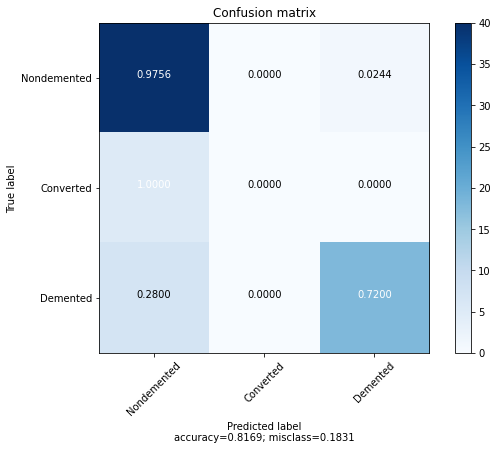

In [4]:
# Make model predictions
predictions   = my_model.predict(test_features)
predictions   = np.round(predictions, 1)
my_pred       = []
for i, vals in enumerate(predictions):
  my_pred.append(list(np.append(predictions[i],
                                inv_label_conversions["Group"][np.argmax(vals)])))

# Make a results dataframe
res_dict = {"confidence(Nondemented" : [],
            "confidence(Converted)"  : [],
            "confidence(Demented)"   : [],
            "prediction(Group)"      : []
            }
for vals in my_pred:
  for i, tag in enumerate(res_dict):
    res_dict[tag].append(vals[i])
results_df = test_df.copy(deep=True)
for tag in res_dict:
  results_df[tag] = res_dict[tag]

# Convert numeric labels back to strings
for col in inv_label_conversions:
  results_df[col] = results_df[col].replace(inv_label_conversions[col])
display(results_df.head())

# Load true labels and model predictions
prediction = list(results_df["prediction(Group)"])
y_original = list(results_df["Group"])

# Calculate confusion matrix and metrics
cm_labels                = ['Nondemented', 'Converted', 'Demented']
cm                       = confusion_matrix(y_original, prediction, labels=cm_labels)
precision, recall, f1, _ = score(y_original, prediction)
plot_confusion_matrix(cm, cm_labels, "model_confusion_matrix")

## **2. Imaging neural network**

### 2.1 Train model

Epoch 1/300
6/6 [==============================] - 1s 58ms/step - loss: 1.0881 - accuracy: 0.4055 - val_loss: 1.1176 - val_accuracy: 0.3448
Epoch 2/300
6/6 [==============================] - 0s 13ms/step - loss: 1.0763 - accuracy: 0.4055 - val_loss: 1.1130 - val_accuracy: 0.3448
Epoch 3/300
6/6 [==============================] - 0s 12ms/step - loss: 1.0764 - accuracy: 0.3976 - val_loss: 1.1084 - val_accuracy: 0.3793
Epoch 4/300
6/6 [==============================] - 0s 10ms/step - loss: 1.0755 - accuracy: 0.4016 - val_loss: 1.1040 - val_accuracy: 0.4138
Epoch 5/300
6/6 [==============================] - 0s 10ms/step - loss: 1.0838 - accuracy: 0.4094 - val_loss: 1.1001 - val_accuracy: 0.4483
Epoch 6/300
6/6 [==============================] - 0s 10ms/step - loss: 1.0717 - accuracy: 0.4449 - val_loss: 1.0959 - val_accuracy: 0.4483
Epoch 7/300
6/6 [==============================] - 0s 11ms/step - loss: 1.0625 - accuracy: 0.4646 - val_loss: 1.0917 - val_accuracy: 0.4138
Epoch 8/300
6/6 [===

[0.8410557508468628, 0.6619718074798584]

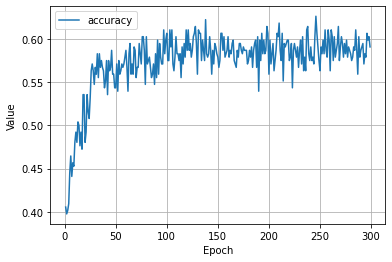

In [5]:
# Create feature layer
feature_columns = []
for feature_name in ["eTIV", "nWBV", "ASF"]:
  feature_values = tf.feature_column.numeric_column(feature_name)
  feature_columns.append(feature_values)
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# The following variables are the hyperparameters.
learning_rate    = 0.0006
epochs           = 300
batch_size       = 50
validation_split = 0.1

# Establish the model's topography.
my_imaging_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, hist = train_model(my_imaging_model, train_df, epochs,
                           label_name, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot,
           "imaging_model_training_accuracy")

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label    = np.array(test_features.pop(label_name))
print("\nEvaluate the new model against the test set:")
my_imaging_model.evaluate(x=test_features, y=test_label, 
                          batch_size=batch_size)

### 2.2 Evaluate model

,ASF,CDR,Group,MMSE,MR_delay,Sex,Visit,eTIV,nWBV,confidence(Nondemented,confidence(Converted),confidence(Demented),prediction(Group)
0,-2.268033,0.0,Nondemented,-0.110327,-0.938740,M,1,2.825198,-0.891939,0.6,0.0,0.4,Nondemented
5,1.829082,0.0,Nondemented,0.159024,-0.938740,F,1,-1.562664,-0.537725,0.3,0.1,0.6,Demented
7,-1.128760,0.0,Nondemented,0.159024,-0.938740,M,1,1.129895,-0.485145,0.5,0.1,0.4,Nondemented
14,1.476315,0.0,Nondemented,0.428375,0.219556,F,2,-1.323591,-0.704342,0.3,0.1,0.6,Demented
19,0.894730,0.0,Nondemented,0.428375,-0.938740,F,1,-0.891075,0.475904,0.5,0.1,0.3,Nondemented


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


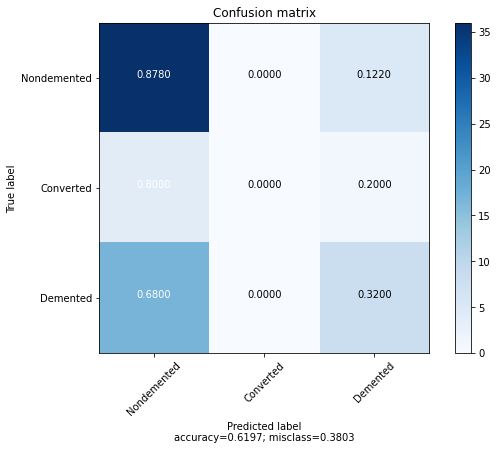

In [6]:
# Make model predictions
imaging_predictions   = my_imaging_model.predict(test_features)
imaging_predictions   = np.round(imaging_predictions, 1)
my_pred               = []
for i, vals in enumerate(imaging_predictions):
  my_pred.append(list(np.append(imaging_predictions[i],
                                inv_label_conversions["Group"][np.argmax(vals)])))

# Make a results dataframe
res_dict = {"confidence(Nondemented" : [],
            "confidence(Converted)"  : [],
            "confidence(Demented)"   : [],
            "prediction(Group)"      : []
            }
for vals in my_pred:
  for i, tag in enumerate(res_dict):
    res_dict[tag].append(vals[i])
imaging_results_df = test_df
for tag in res_dict:
  imaging_results_df[tag] = res_dict[tag]

# Convert numeric labels back to strings
for col in inv_label_conversions:
  imaging_results_df[col] = results_df[col].replace(inv_label_conversions[col])
display(imaging_results_df.head())

# Load true labels and model predictions
prediction = list(imaging_results_df["prediction(Group)"])
y_original = list(imaging_results_df["Group"])

# Calculate confusion matrix and metrics
cm_labels                = ['Nondemented', 'Converted', 'Demented']
cm                       = confusion_matrix(y_original, prediction, labels=cm_labels)
precision, recall, f1, _ = score(y_original, prediction)
plot_confusion_matrix(cm, cm_labels, "imaging_model_confusion_matrix")